In [18]:
import matplotlib.pyplot as plt
from networkx import nx
from networkx.readwrite import json_graph
import json
import random as rn
import numpy as np
import datetime as datetime
from numpy.random import choice as np_choice

# Создаем и сохраняем граф
Создаем и записываем граф в файл, это необходимо, чтобы тестировать и обучать популяции по Ламарку и по Дарвину можно было в одинаковых условиях (на одинаковых графах).

Также было принято решение отказаться от направленного графа для упрощения задачи. Сложность вызвало создание направленного графа в котором гарантировано будет хотя бы один маршрут из точки А в точку Б.*Курсив*

In [89]:
def generate_graph(_iteration_number):
  n = 10  # TODO: 1024 nodes
  m = 20  # от N до 3xN ???
  general_graph = nx.gnm_random_graph(n, m, directed=False)
  export_graph = json_graph.node_link_data(general_graph)
  with open('/content/sample_data/darvin_graph_'+iteration_number+'.json', 'w') as writefile:
    writefile.write(json.dumps(export_graph))

In [90]:
iteration_number = '11'
#generate_graph(iteration_number)

0
[(0, 2), (0, 4), (0, 8), (0, 3)]
1
[(1, 9), (1, 5)]
2
[(2, 0), (2, 5), (2, 7)]
3
[(3, 0), (3, 4), (3, 5), (3, 8), (3, 9), (3, 7)]
4
[(4, 0), (4, 3), (4, 9), (4, 8)]
5
[(5, 1), (5, 2), (5, 3), (5, 7), (5, 6)]
6
[(6, 5), (6, 7), (6, 9)]
7
[(7, 2), (7, 3), (7, 5), (7, 6), (7, 9)]
8
[(8, 0), (8, 3), (8, 4)]
9
[(9, 1), (9, 3), (9, 4), (9, 6), (9, 7)]


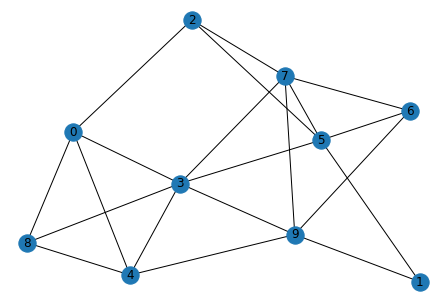

In [91]:
# Считываем граф из файла
file_name = "darvin_graph_"+iteration_number+".json"
g = nx.DiGraph()
with open('/content/sample_data/'+file_name, 'r') as readfile:
  js_graph = json.load(readfile)
  g = json_graph.node_link_graph(js_graph, directed=True)

# итерация узлов
for i in range(0, len(g.nodes)):
  print(i)
  print(g.edges(i))


# Рисуем граф если граф тестовый (граф из 1024 точек адекватно не отображается)
if len(g.nodes)<50 :
  nx.draw(g, with_labels=True)
  plt.show()


# Генетический алгоритм, с популяцией по Дарвину
Cчитаем что точка А - это G[0], точка B - это G[nodes-1].  

0) Стартовая популция - число частиц в точке A. Задается, как гиперпараметр n_start. Частица имеет следюущую структуру:


> coord - координаты местонахожления (вершина графа)  
  w - вес частицы (стартовое значение 1)  
  r - расстояние (длина кратчайшего пути от coord до точки B)


1) Кажда частица совершает случайные блуждания по маршруту n_iterations раз, пока не достигнет цели(точки B) или не "умрет":  
> 1.1) Совершаем max_item_iterations случайных переходов частицей или пока не достигнем цели.  
  1.2) Если частица достигла цели, инкрементируем число достигших цели точек и "убиваем" частицу. Если частица не достигла цели, пересчитываем её вес.  
  1.3) Вес рассчитывается, как:  
  *тут картинка*
   где n - текущая итерация,  
   lambda - ???  
   r - расстояние от coord до B  
   e - константа ~2.72  
  1.4) Если новый w(вес частицы) < 1, с вероятностью w - "убиваем" частицу.  
  1.5) Если новый w(вес частицы) >1, расщепляем частицу на две, с весами w/2.

2) Завершаем алгоритм, если все выжившие частицы достигли цели или если все частицы погибли или пройден лимит итераций.
3) Выводим число пройденных итераций, число частиц достигших цели, время выполнения алгоритма.


# FIXME: 
Веса рассчитываются рандомно, а не поформуле.  
Есть баг в подсчете число достигнуых целей

In [93]:
class DarvinColony(object):

  def __init__(self, graph, n_start, n_iterations, max_item_iterations, alpha=1, beta=1):
    self.graph = graph # Итерируемый граф
    self.distances  = nx.to_numpy_array(graph) # Матрица переходов
    self.n_start = n_start # Размер начальной популяции
    self.n_iterations = n_iterations # Число итераций блуждания
    self.max_item_iterations = max_item_iterations # Максимальное число переходов за итерацию блуждания

    self.quantums = [] # Массив частиц
    self.targetIterations = 0 # Число затраченых итераций
    self.targetQuantums = 0 # Число частиц достигших цели
    self.time_start = 0 # Время старта итераций
    self.time_end = 0 # Время завершения итераций

  # Запускаем итерации частиц (соответствует Шагу 1)
  def run(self):
    self.time_start = datetime.datetime.now()
    best_way = 1 # TODO: Кратчайший путь от A до B, если он используется как стартовый параметр r
    self.genQuantums(best_way)

    self.targetIterations = self.n_iterations
    for i in range(0, self.n_iterations):
      print("---- Итерация #{} ----".format(i))
      self.gen_all_paths() #  Каждая частица совершает случайные блуждания (Шаги 1.1-1.2)
      self.recalcWeight() # Пересчет весов (Шаг 1.3)
      self.kill() # Убийство частиц с учетом весов (Шаг 1.4)
      self.reproduction() # Размножение чатиц с учетом весов (Шаг 1.5)
      if len(self.quantums) == 0:
        self.targetIterations = i
        break
    self.time_end = datetime.datetime.now()
    
    print("---- Стартовые гиперпараметры ----")
    print("Размер популяции {}, лимит итераций {}, лимит блужданий {}".format(self.n_start, self.n_iterations, self.max_item_iterations))
    print("---- Результаты ----")
    print("Число частиц достигших цели {}, за {} итераций, за время {} сек".format(self.targetQuantums,  self.targetIterations, self.time_end - self.time_start))

  # Инициализируем частицы
  def genQuantums(self, best_way):
    for i in range(0, self.n_start):
      self.quantums.append({'coord': 0, 'w': 1, 'r': best_way})

  def recalcWeight(self):
    for i in range(0, len(self.quantums)):
      # TODO: перерасчет r в связи со сменой coord
      # перерасчет w
      self.quantums[i]['w'] = rn.randint(50, 220)/100 # FIXME: рандом, пока не понял формулу
  
  def kill(self):
    toKill = []
    # механизм рулетки
    for item, quantum in enumerate(self.quantums):
      if quantum['w'] < 1 :
        if rn.random() > quantum['w'] :
          toKill.append(item)

    #убиваем частицы выпавшие на рулекте
    i = 0
    for item in range(len(toKill)-1):
      del self.quantums[item-i]
      ++i 

  def reproduction(self):
    toReproduct = []
    for item, quantum in enumerate(self.quantums):
      if quantum['w'] > 1 :
        toReproduct.append(item)

    # FIXME: надо ли делть больше чем на 2 частицы?
    for i in range(len(toReproduct)):
      self.quantums[i]['w'] = self.quantums[i]['w']/2
      new_quant = {'coord': self.quantums[i]['coord'], 'w': self.quantums[i]['w'], 'r': self.quantums[i]['r']}
      self.quantums.append(new_quant)
      

  # Получение всех блужданий за одну итерацию
  def gen_all_paths(self):
    toKill = []
    # генерируем случаыне блуждания для всех живых частиц
    for item, quantum in enumerate(self.quantums):
      target = self.gen_path(item) 
      if target == 1:
        toKill.append(item)
    
    #убиваем частицы достигшие цели
    i = 0
    for item in range(len(toKill)-1):
      del self.quantums[item-i]
      ++i

  def gen_path(self, item):
    prev = self.quantums[item]['coord']
    i = 0
    # совершаем переходы, пока не достигли вершины B или лимита блужданий
    while (i < self.max_item_iterations):
      neighbours = list(self.graph.adj[prev])
      self.quantums[item]['coord'] = rn.choice(neighbours)
      prev = self.quantums[item]['coord']
      # если достигли точки B
      if self.quantums[item]['coord'] == (len(g.nodes)-1):
        print("цель достигнута")
        self.targetQuantums = self.targetQuantums+1
        return 1
      ++i
    
    return 0

#Здесь буду результаты испытаний с разными  гиперпараметрами 

In [95]:
#TODO: запускаем в цикле с различными параметрами
colony = DarvinColony(g, 3, 10, 2)
colony.run()

---- Итерация #0 ----
цель достигнута
цель достигнута
цель достигнута
---- Итерация #1 ----
цель достигнута
цель достигнута
---- Итерация #2 ----
цель достигнута
цель достигнута
---- Итерация #3 ----
цель достигнута
цель достигнута
---- Итерация #4 ----
цель достигнута
цель достигнута
---- Итерация #5 ----
цель достигнута
---- Итерация #6 ----
цель достигнута
---- Итерация #7 ----
цель достигнута
цель достигнута
---- Итерация #8 ----
цель достигнута
цель достигнута
---- Итерация #9 ----
цель достигнута
цель достигнута
---- Стартовые гиперпараметры ----
Размер популяции 3, лимит итераций 10, лимит блужданий 2
---- Результаты ----
Число частиц достигших цели 19, за 10 итераций, за время 0:00:00.008007 сек
